# Bike Rental Data
This project analyzes bike trip data from the San Francisco Bay area. The original dataset comes from **TBD** and includes the following columns:
- `tripduration` (int64) - length of rental in seconds
- `starttime` (object) - rental start time
- `stoptime` (object) - rental stop time
- `start station id` (int64) - id of start station 
- `start station name` (object) - name of start station
- `start station latitude` (float64) - latitude of start station
- `start station longitude` (float64) - longitude of start station
- `end station id` (int64) - id of end station
- `end station name` (object) - name of end station
- `end station latitude` (float64) - latitude of end station
- `end station longitude` (float64) - longitude of end station
- `bikeid` (int64) - id of rental bike
- `usertype` (object) - type of user ('Subscriber' or 'Customer')
- `birth year` (object) - birth year of renter (if known)
- `gender` (int64) - gender of renter (if known)

In this exploratory data analysis, I am interested in discovering the following:
1. Are there any behavioral differences between user types? And if so, what are they?
    1. Rental count / duration, by day of week or by hour of day
    2. Distance traveled or rental duration
    3. 
2. Are there any significant differences in user types along the lines of gender or age?
    1. 
3. Which stations are most popular for rentals overall? By day of week? By hour of day? And does this vary by user type?

4. Station popularity
    1. Which stations are most popular overall? By user type? By day of week? By hour of day?
    2. Which station is most popular for starting a trip? ending a trip?
    3. Which trips are most popular (start station to end station) and how does this vary across our key dimensions (i.e., user type, day of week, hour of day)

5. How much does total rental time vary across bikes? 

Other:
1. Look for fraud
2. How do holidays impact rentals?
3. 

## Import Libraries

In [15]:
# Import packages
import pandas as pd
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("whitegrid")
sns.set(color_codes=True)

# Set display option for floats in Pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Read in & Preview the Data

In [2]:
# Read in the data and review
df = pd.read_csv('../data/bike_rental_data.csv')
print(df.shape)

(1037712, 15)


In [3]:
df.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,326,2013-10-01 00:01:08,2013-10-01 00:06:34,239,Willoughby St & Fleet St,40.69,-73.98,366,Clinton Ave & Myrtle Ave,40.69,-73.97,16052,Subscriber,1982,1


## Data Review and Cleanup

### Check for Missing Values

In [4]:
# Check for missing values
df.isna().sum()

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
birth year                 0
gender                     0
dtype: int64

### Rename Columns

In [5]:
# Rename columns to remove spaces
cols = []
for col in df.columns.to_list():
    col = col.replace(' ','_')
    cols.append(col)
df.columns = cols
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype',
       'birth_year', 'gender'],
      dtype='object')

In [107]:
print(df.starttime.min())

2013-10-01 00:01:08


### Review & Cleanup Duration Data
TBD

In [6]:
# Create a new column for duration in minutes and round to nearest minute
df['tripduration_min'] = round((df.tripduration / 60),0).astype(int)

In [7]:
# Review duration statistics
mean = round(np.mean(df.tripduration_min),0).astype(int)
median = round(np.median(df.tripduration_min),0).astype(int)
mode = stats.mode(df.tripduration_min)[0][0]
print ("Trip Duration:")
print("Mean ~ " + str(mean) + " minutes")
print("Median ~ " + str(median) + " minutes")
print("Mode ~ " + str(mode) + " minutes")

Trip Duration:
Mean ~ 14 minutes
Median ~ 10 minutes
Mode ~ 6 minutes


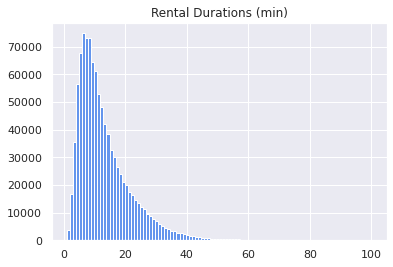

In [8]:
# Plot duration on a histogram
plt.hist(df.tripduration_min, bins=100, range=(1,100), color='cornflowerblue')
plt.title('Rental Durations (min)');

In [9]:
df.tripduration_min.describe()

count   1037712.00
mean         13.76
std          33.34
min           1.00
25%           7.00
50%          10.00
75%          17.00
max       20991.00
Name: tripduration_min, dtype: float64

In [11]:
df[df.tripduration_min > 50].tripduration_min.count()

10763

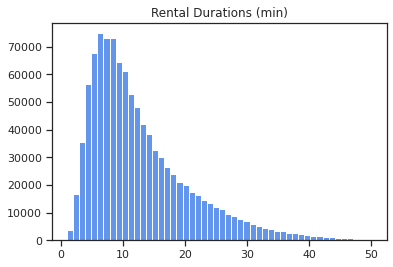

In [23]:
# Remove outlier trips with above 50 min
df = df[df.tripduration_min <= 50]

# And now to plot duration on a histogram using the adjusted df
plt.hist(df.tripduration_min, bins=50, range=(1,50), color='cornflowerblue')
plt.title('Rental Durations (min)');

In [24]:
# And to review our duration stats again
df.tripduration_min.describe()

count   1026949.00
mean         12.59
std           8.34
min           1.00
25%           7.00
50%          10.00
75%          16.00
max          50.00
Name: tripduration_min, dtype: float64

In [25]:
1026949/1037712*100

98.96281434540604

When we remove the outlier trips, we can see that the average trip is just over 12 min. This required removing about 1% of the data...1026949 rows vs. 1037712 rows.

### Review Gender Column Data

In [26]:
# Review gender column data
df.groupby(['usertype', 'gender']).usertype.count()

usertype    gender
Customer    0          90974
            1              1
Subscriber  0             52
            1         711435
            2         224487
Name: usertype, dtype: int64

### Review Birth Year Data

In [27]:
# Review birth year column data
df.groupby(['usertype', 'birth_year']).usertype.count()

usertype    birth_year
Customer    1995              1
            \N            90974
Subscriber  1899             54
            1900            202
            1901             36
                          ...  
            1993           7685
            1994           4552
            1995           2442
            1996           1372
            1997           1005
Name: usertype, Length: 83, dtype: int64

### Review Date Info
TBD

In [28]:
# Convert start_date and end_date to datetime format
df.starttime = pd.to_datetime(df.starttime, infer_datetime_format=True)
df.stoptime = pd.to_datetime(df.stoptime, infer_datetime_format=True)

# Create new column for hour of rental
df["starthour"] = df.starttime.dt.hour

# Check new values
df.groupby(['starthour']).starthour.count().head()

starthour
0    10681
1     6054
2     3715
3     2082
4     1943
Name: starthour, dtype: int64

In [29]:
# Create new column for day of week
df["startdow"] = df.starttime.dt.dayofweek

# Create a binary representation of weekend
df["is_weekend"] = 0
df.loc[df['startdow'] >= 5, 'is_weekend'] = 1

# Create user friendly version of startdow column
days_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['day'] = df.startdow.map(days_dict)

# Check new values
df.groupby(['startdow','day', 'is_weekend']).day.count()

startdow  day        is_weekend
0         Monday     0             123339
1         Tuesday    0             184757
2         Wednesday  0             181384
3         Thursday   0             171063
4         Friday     0             141364
5         Saturday   1             118412
6         Sunday     1             106630
Name: day, dtype: int64

## Behavior Analysis
TBD - description of what we want to analyze in terms of customer behavior

## Rental Count Analysis

### Rental Count by Hour

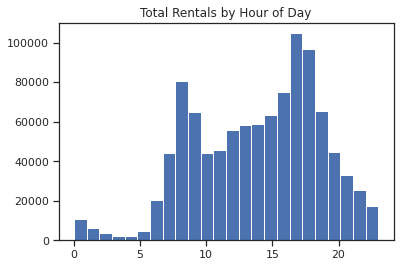

In [42]:
# Plot a histogram of the hour of rental
plt.hist(df.starthour, bins=24)
plt.title('Total Rentals by Hour of Day');

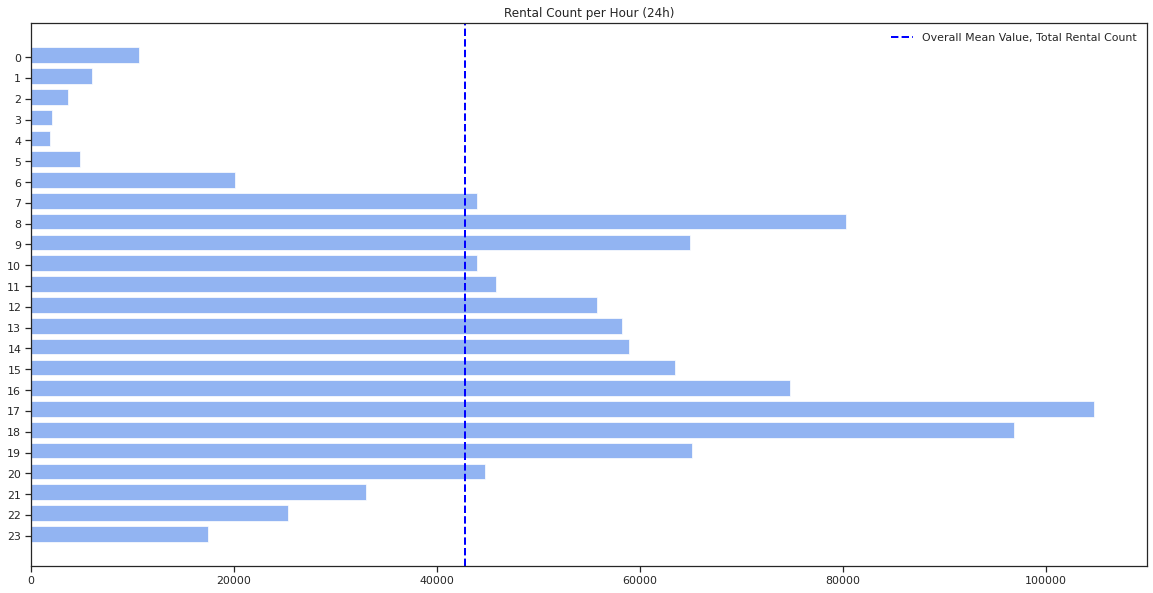

In [47]:
# Plotted as a bar chart
# x values are the unique hours of the day
temp_df = df.sort_values(by=['starthour'], ascending=True)
hours = temp_df.starthour.unique().tolist()

# y values are the sum of the count for each hour of the day
rentals_per_hour = temp_df.groupby(['starthour']).starthour.count()
y_values = rentals_per_hour.tolist()

# Plot rentals based on the hour of the day
width = 0.75 # the width of the bars 
ind = np.arange(len(rentals_per_hour))  # the x locations for the groups
plt.figure(figsize=(20,10))
plt.barh(ind, y_values, width, color='cornflowerblue', alpha=0.7)
plt.axvline(rentals_per_hour.mean(), color='blue', linestyle='dashed', linewidth=2, label='Overall Mean Value, Total Rental Count')
plt.yticks(ind+width/8, labels=hours)
plt.title('Rental Count per Hour (24h)')     
plt.gca().invert_yaxis()
plt.legend(loc='upper right');
plt.show()

Looks like the peak hours of the day are during standard commute times (8-10 am and 4-7 pm) with another small spike between 12-1 pm.

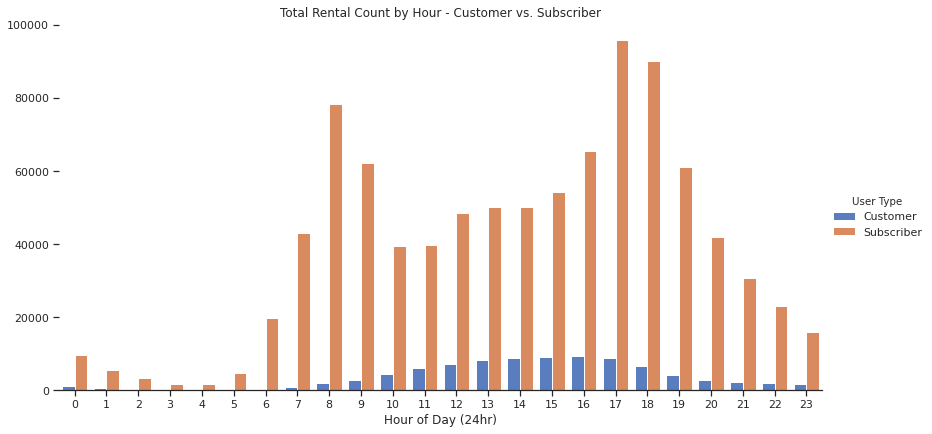

In [96]:
temp_df_hour = df.groupby(["starthour","usertype"]).usertype.count().reset_index(name="count")
g = sns.catplot(x="starthour", y="count", hue="usertype", data=temp_df_hour, height=6, aspect=2,\
                kind="bar", palette="muted", legend_out=True)
g.despine(left=True)
g.set(xlabel='Hour of Day (24hr)', ylabel=None,\
      title="Total Rental Count by Hour - Customer vs. Subscriber")
g._legend.set_title("User Type");

In [97]:
temp_df_hour = temp_df_hour.pivot_table(index='starthour', values='count', columns='usertype')

usertype,Customer,Subscriber
starthour,,
0,1085,9596
1,639,5415
2,483,3232
3,246,1836
4,147,1796


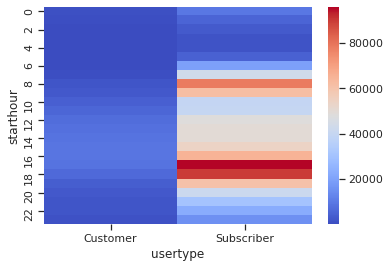

In [110]:
sns.heatmap(temp_df_hour, cmap='coolwarm')

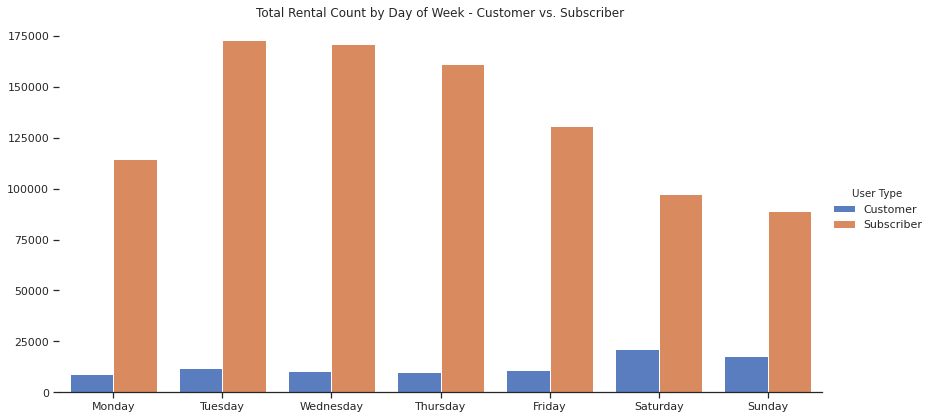

In [87]:
temp_df_dow = df.groupby(["startdow","day","usertype"]).usertype.count().reset_index(name="count")
g = sns.catplot(x="day", y="count", hue="usertype", data=temp_df_dow, height=6, aspect=2, kind="bar",\
                palette="muted", legend_out=True)
g.despine(left=True)
g.set(xlabel=None, ylabel=None,
      title="Total Rental Count by Day of Week - Customer vs. Subscriber")
g._legend.set_title("User Type");

In [100]:
temp_df_dow = temp_df_dow.pivot_table(index='day', values='count', columns='usertype')

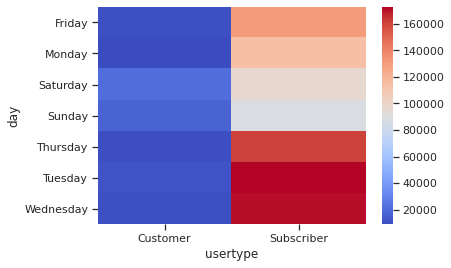

In [111]:
sns.heatmap(temp_df_dow, cmap='coolwarm');

Again, more evidence that rentals are higher during the work week. Above we see that rental volumes are markedly reduced during Saturday and Sunday.

## Station Popularity

### Popularity by Total Rental Count

In [115]:
# Determine top 10 stations based on total rental count
df['count'] = 1
df.pivot_table(index=["start_station_name"], values="count",\
                  aggfunc=np.sum).sort_values("count", ascending=False).head(10)

,count
start_station_name,
8 Ave & W 31 St,11108
Pershing Square N,11107
E 17 St & Broadway,10541
Lafayette St & E 8 St,10404
W 20 St & 11 Ave,9717
Broadway & E 14 St,9050
University Pl & E 14 St,8883
West St & Chambers St,7960
W 21 St & 6 Ave,7936


### Popularity by Average Rental Duration

In [116]:
# Determine top 10 stations based on total rental duration
df.pivot_table(index=["start_station_name"], values=["count","tripduration_min"],\
                  aggfunc={"count": np.sum,"tripduration_min": np.mean}).sort_values("tripduration_min", ascending=False).head(10)

,count,tripduration_min
start_station_name,,
Central Park S & 6 Ave,3429,21.53
Wythe Ave & Metropolitan Ave,1621,20.63
State St,2282,20.49
Old Fulton St,1203,20.14
Dean St & 4 Ave,1553,20.08
S 5 Pl & S 4 St,2225,19.72
Atlantic Ave & Furman St,991,19.71
South St & Whitehall St,1803,19.63
South St & Gouverneur Ln,2576,19.24


## Subscription Type Analysis

In [117]:
# Determine average duration for subscriber vs. customer
df.pivot_table(index=["usertype"], values=["count","tripduration_min"],\
                  aggfunc={"count": np.sum,"tripduration_min": np.mean}).\
                  sort_values("tripduration_min", ascending=False).head(10)

,count,tripduration_min
usertype,,
Customer,90975,19.24
Subscriber,935974,11.94


### Average Duration - Subscribers vs. Customers

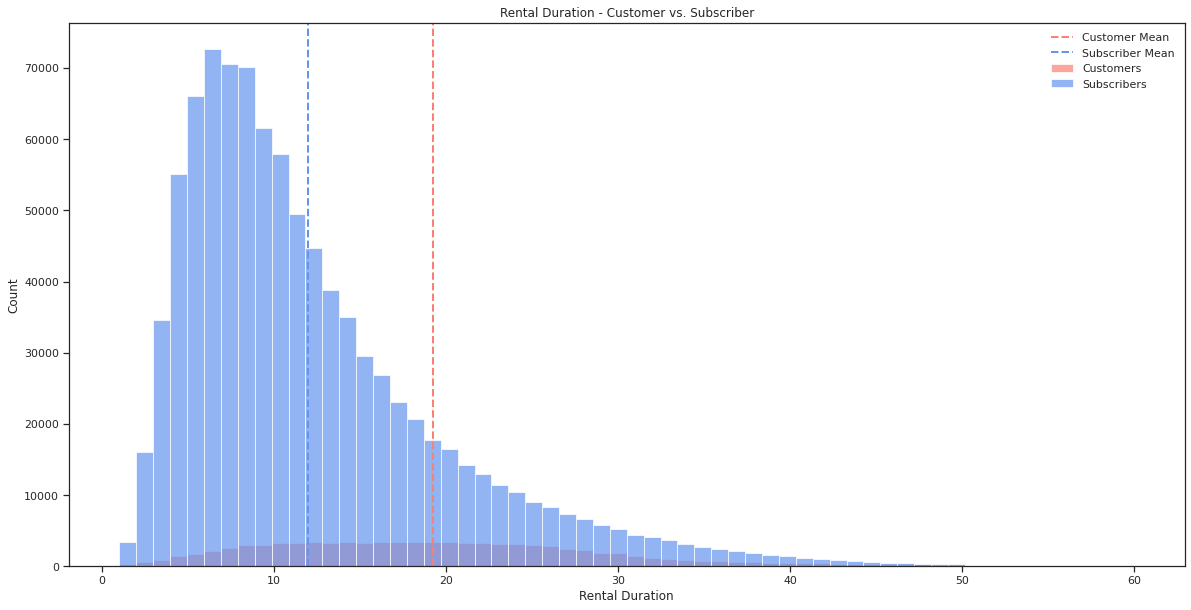

In [118]:
# Plot a histogram of avg rental duration for customers vs. subscribers
x_cus = df[df['usertype'] == 'Customer'].tripduration_min
x_sub = df[df['usertype'] == 'Subscriber'].tripduration_min

plt.figure(figsize=(20,10))
plt.hist(x_cus, bins=60, range=(1,60), color='salmon', alpha=0.7, label='Customers')
plt.hist(x_sub, bins=60, range=(1,60), color='cornflowerblue', alpha=0.7, label='Subscribers')
plt.axvline(x_cus.mean(), color='salmon', linestyle='dashed', linewidth=2, label='Customer Mean')
plt.axvline(x_sub.mean(), color='cornflowerblue', linestyle='dashed', linewidth=2, label='Subscriber Mean')
plt.xlabel("Rental Duration")
plt.ylabel("Count")
plt.title('Rental Duration - Customer vs. Subscriber')
plt.legend(loc='upper right');

Based on this data, it looks like we can start to draw some initial conclusions.

1. Subscribers are much more likely to rent bikes in general
2. Customers rent bikes for about twice as long on average as subscribers

Assuming subscribers are paying some sort of monthly subscription fee in addition to a per min rate, it would appear that the best way to increase revenue for the program would be to increase the number of subscribers. Although, without exact numbers for the program, this is a tough conclusion to make. 

If subscribers pay a monthly fee that **includes** a specified amount of minutes, this could explain why the average duration is lower for subscribers who may not want to exceed their monthly allocation. In contrast, as a one-off customer, it is likely a bigger decision to rent a bike to begin with and it's reasonable to think that these rentals occur most frequently when a person has a long distance to travel - i.e., a distance so long that they would prefer to ride than walk.

Let's see if we can prove this out by comparing the distances traveled for subscribers vs. customers. But first, let's see if the differences we are seeing above are statistically significant.

## Time Series Analysis - Rentals Per Day Over Time

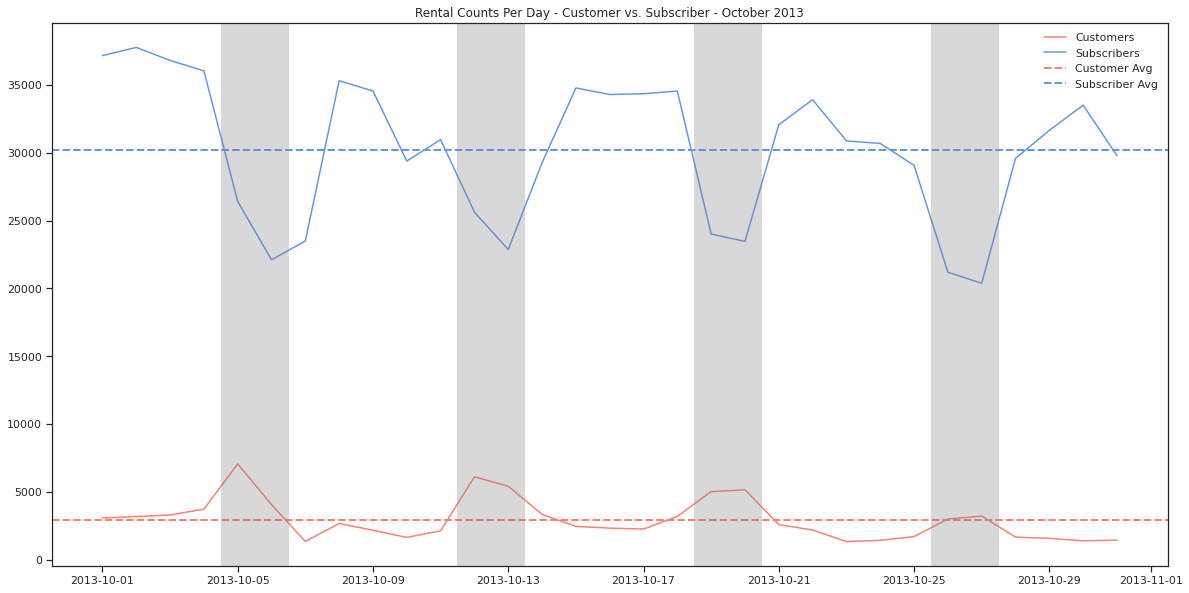

In [179]:
###TODO
# 1. Add xlim to remove the extra space on each side of the plot
# 2. Figure out how to label the weekend bars

# Create a plot showing rental count per day over time for Customers vs. Subscribers
plt.figure(figsize=(20,10))
g = sns.lineplot(x, y_cus, color='salmon', label='Customers')
sns.lineplot(x, y_sub, color='cornflowerblue', label='Subscribers')

# Plot horizontal lines to show the average daily rental count for each group
plt.axhline(y_cus.mean(), color='salmon', linestyle='dashed', linewidth=2, label='Customer Avg')
plt.axhline(y_sub.mean(), color='cornflowerblue', linestyle='dashed', linewidth=2, label='Subscriber Avg')

# Create a list of weekend dates
dateList = df.starttime.dt.date.unique()
weekends = []
for date in dateList:
    if date.weekday() >= 5:
        weekends.append(date)

# Plot a vertical gray bar to designate weekend days
for date in weekends:
    plt.axvline(date, color='gray', alpha=0.3, linewidth=34)

# Add limits, labels and title
# g.plt.xlim(TBD)
g.set(xlabel=None, ylabel=None,
      title='Rental Counts Per Day - Customer vs. Subscriber - October 2013');
plt.legend(loc='upper right');